In [23]:
import numpy as np
import pandas as pd
import math
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from operator import itemgetter
import nltk
from nltk.stem import WordNetLemmatizer
from numpy import dot
from numpy.linalg import norm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def cos_sim(A, B):
       return round(dot(A, B)/(norm(A)*norm(B)),3)


with open('../data/top_songs2.pickle', 'rb') as handle:
    dic = pickle.load(handle)

# data = pd.read_csv('mylyrics00.csv')

singer_list=list(dic.keys())
song_list=list(dic.values())



stop_word = set(stopwords.words('english'))
doc = []
for i in range(len(song_list)):
    tmp=""
    for key in song_list[i].keys():
        temp=song_list[i][key]
        tmp=tmp+" "+temp

    
    
    list_temp = regexp_tokenize(tmp.lower(), "[a-z]['a-z]*")

    result = []
    for w in list_temp:
        if w not in stop_word:
            result.append(w)
    doc.append([singer_list[i],result])
singer=singer_list

In [24]:
class List:
    class Node:
        def __init__(self, doc,dtf): #node는 doc_number,dtf link로 구성
            self.doc = doc
            self.dtf=dtf
            self.next = None

    def __init__(self,term): #head는 term,freq,link로 구성
        self.head = None
        self.term=term
        self.freq = 0

    def freq(self):
        return self.freq

    def term(self):
        return self.term

    def add(self,doc,dtf):
        p=self.head
        if p==None:
            self.head=self.Node(doc,dtf)
        else:
            while (p.next != None):
                p=p.next
            p.next = self.Node(doc,dtf)
        self.freq += 1

    def print_list(self): # doc_number를 출력하기 위한 함수
        p=self.head
        res=[]
        while p is not None:
            res.append(p.doc)
            p=p.next
        return res

In [25]:
def listing(index): #LINKED LIST head:term,doc_freq // node: doc_num, freq in doc_num
    list_set=[]

    tmp_t=index[0][0]
    tmp_d=index[0][1]
    cnt=1
    for i in range(1,len(index)):
        tmp_term=index[i][0]
        tmp_doc=index[i][1]

        if(tmp_term==tmp_t and tmp_doc==tmp_d):
           cnt+=1
        else:
            list_set.append([tmp_t,tmp_d,cnt])
            cnt=1
        tmp_t=tmp_term
        tmp_d=tmp_doc
    list_set.append([tmp_t, tmp_d, cnt])

    list_all=[]
    term=list_set[0][0]
    list_t=List(term)
    list_t.add(list_set[0][1],list_set[0][2])
    for i in range(1,len(list_set)):
        if(term!=list_set[i][0]):
            list_all.append(list_t)
            list_t=List(list_set[i][0])
        list_t.add(list_set[i][1],list_set[i][2])
        term=list_set[i][0]
    list_all.append(list_t)

    return list_all

def indexing():  #vsm
    vsm_word1 = []
    index_doc=[]
    indexed_list1=[]
    for i in range(len(doc)):
        for j in range(len(doc[i][1])):
            index_doc.append([doc[i][1][j],i])

    index_doc.sort(key=itemgetter(0))

    indexed_list1=listing(index_doc)

    for i in range(len(indexed_list1)):  # 각 단어별 weight 계산 단어 1개
        vsm_word1.append([0 for j in range(len(doc) + 1)])
        vsm_word1[i][0] = indexed_list1[i].term
        p = indexed_list1[i].head
        while (p != None):
            w = (1 + math.log2(p.dtf)) * math.log2(len(doc) / indexed_list1[i].freq)
            #w=p.dtf
            vsm_word1[i][p.doc + 1] = float(w)
            p = p.next
    return vsm_word1

vsm=indexing()


In [26]:
vsm_=np.zeros((len(vsm),len(vsm[0])-1))
for i in range(len(vsm_)): #vsm
        for j in range(len(vsm_[i])):
            vsm_[i][j]=vsm[i][j+1]
vsm_t=vsm_.T

In [27]:
cos_sim_a=[]

for i in range(len(singer)):
    list_sim=[]
    for j in range(len(singer)):
        list_sim.append(cos_sim(vsm_t[i],vsm_t[j]))
  
    cos_sim_a.append(list_sim)


In [28]:
def GetThreshold(cossim):
    t = sum(cossim, [])
    std = np.std(t)
    mean = np.mean(t)
    
    return mean + std * 0.4, mean

In [29]:
# large : large 값 보다 크다면 큰 관계가 있다.
# small : large 값보단 작지만 small 값 보다 크다면 약간의 관계가 있다. small 값 이하라면 관계가 없다.
def ShowNetworkGraph(singer, cos_sim_a, large, small):
    GS = nx.Graph()
    
    for n in range(len(singer)):
        for m in range(0, len(singer) - n - 1):
            GS.add_edge(singer[n],singer[n+1+m], weight = cos_sim_a[n][m])

    
    GSelarge = [(u,v) for (u,v,d) in GS.edges(data=True) if d['weight'] > large]
    GSesmall = [(u,v) for (u,v,d) in GS.edges(data=True) if d['weight'] <= large and d['weight'] > small]
    GSeminor = [(u,v) for (u,v,d) in GS.edges(data=True) if d['weight'] <= small]
    
    GSpos = nx.spring_layout(GS)
    
    # 전체 그래프 크기
    plt.figure(figsize=(16, 8))
    
    plt.gca().axis('off')
    plt.margins(x=0.1, y=0.02)
    
    # node
    nx.draw_networkx_nodes(GS, GSpos, node_size=0)
    
    # edge_color - 연결선 색 변경
    # width - 연결선 굵기 변경
    # alpha - 연결선 투명도 조절
    # large edge
    nx.draw_networkx_edges(GS, GSpos, edgelist=GSelarge, edge_color = 'b', width = 6, alpha=0.3)
    
    # small edge
    nx.draw_networkx_edges(GS, GSpos, edgelist=GSesmall, width = 3, alpha = 0.2, edge_color = 'y', style = 'dashed')
    
    #nx.draw_networkx_edges(GS, GSpos, edgelist=GSeminor, width = 1, edge_color = 'r', style='dotted')


    # font_family - 글꼴 변경
    # font_color - 글자 색변경
    # font_size - 글자 크기 변경
    # font_weight - 기타 옵션
    nx.draw_networkx_labels(GS, GSpos, font_family='sans-serif', font_color='Black', font_size=11, font_weight='bold')

    plt.show()

In [8]:
large, mid = GetThreshold(cos_sim_a)

C:\Users\KimJaeHwan\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


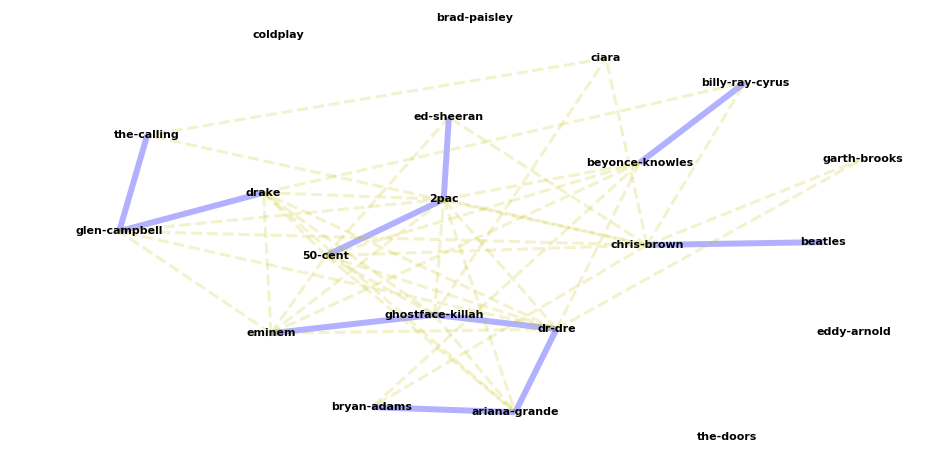

In [9]:
ShowNetworkGraph(singer, cos_sim_a, large, mid)

# Max accuracy

In [10]:
for i in range(len(cos_sim_a)):
    test = cos_sim_a[i][:]
    test.pop(test.index(max(test)))
    a = cos_sim_a[i].index(max(test))
    print("" + singer[i] +"      "  + singer[a]+ " :   " + str(max(test)))

eminem      dr-dre :   0.162
ghostface-killah      50-cent :   0.163
50-cent      ghostface-killah :   0.163
dr-dre      2pac :   0.184
drake      eminem :   0.118
2pac      dr-dre :   0.184
beyonce-knowles      chris-brown :   0.119
ariana-grande      eminem :   0.067
chris-brown      eminem :   0.136
glen-campbell      eddy-arnold :   0.109
ciara      chris-brown :   0.123
ed-sheeran      eminem :   0.1
garth-brooks      glen-campbell :   0.08
billy-ray-cyrus      bryan-adams :   0.078
brad-paisley      eminem :   0.082
bryan-adams      the-calling :   0.085
eddy-arnold      glen-campbell :   0.109
beatles      eminem :   0.072
coldplay      the-calling :   0.053
the-calling      bryan-adams :   0.085
the-doors      ghostface-killah :   0.066


# Min accuracy

In [11]:
for i in range(len(cos_sim_a)):
    a = cos_sim_a[i].index(min(cos_sim_a[i]))
    print("" + singer[i] +"/"  + singer[a]+ " :   " + str(min(cos_sim_a[i])))

eminem/glen-campbell :   0.051
ghostface-killah/coldplay :   0.044
50-cent/coldplay :   0.038
dr-dre/the-calling :   0.037
drake/coldplay :   0.032
2pac/coldplay :   0.042
beyonce-knowles/eddy-arnold :   0.033
ariana-grande/eddy-arnold :   0.029
chris-brown/glen-campbell :   0.038
glen-campbell/ciara :   0.028
ciara/the-calling :   0.025
ed-sheeran/ciara :   0.042
garth-brooks/ciara :   0.037
billy-ray-cyrus/ciara :   0.033
brad-paisley/ariana-grande :   0.035
bryan-adams/ciara :   0.042
eddy-arnold/ciara :   0.026
beatles/ariana-grande :   0.032
coldplay/ciara :   0.025
the-calling/ciara :   0.024
the-doors/ariana-grande :   0.03
